# Linear Regression Notebook
This notebook contains all the linear regression modelling and analysis done for the project. The purpose was to find the best linear regression model that best explained our outcome variable. Our outcome variable is the number of goals met, as determined by the PA Health Department for fetal mortality rate, infant mortality rate, and and percent of pre-term live births. The linear regression model will be used to inform the areas of focus and weights in the optimization portion of this project.

### Setting up and Imputations

In [32]:
## Import libraries
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
from sklearn.preprocessing import StandardScaler


In [33]:
# import cleaned, oversampled dataset
t = pd.read_csv('./data/oversample_data.csv')
feats = t[['county_name', 'population', 'pop_change_2010', 'perc_under_18',
       'perc_csec', 'perc_prenat_1tri', 'perc_non_smoke', 'fert_15_44',
       'birth_rate_15_19', 'birth_rate_20_24', 'birth_rate_25_29',
       'birth_rate_30_34', 'birth_date_35_39', 'birth_rate_40_44',
       'all_cause_death', 'chlam_per_100000', 'gono_per_100000', 'perc_smoker',
       'hiv_tested', 'perc_no_healthins', 'perc_obese', 'perc_routine_checkup',
       'beds_per_1000', 'inpatient_occupancy_rate', 'goals_met',
       'population_White', 'population_Black', 'population_Native',
       'population_Asian', 'population_NativeHawaiian_PacificIslander',
       'population_OtherRace', 'adi_staterank_mean']].drop(columns='county_name')
feats.replace({'.': None}, inplace=True)

In [34]:
# rename to match
merged = pd.concat([t[['county_name']], feats], axis=1).rename(columns={'adi_staterank_mean': 'ADI_STATERNK_INT_mean'})
merged

,county_name,population,pop_change_2010,perc_under_18,perc_csec,perc_prenat_1tri,perc_non_smoke,fert_15_44,birth_rate_15_19,birth_rate_20_24,...,beds_per_1000,inpatient_occupancy_rate,goals_met,population_White,population_Black,population_Native,population_Asian,population_NativeHawaiian_PacificIslander,population_OtherRace,ADI_STATERNK_INT_mean
0,Potter,16526.0,-5.3,20.3,35.9,77.8,78.7,68.9,27.7,145.7,...,1.5,49.2,0,0.970932,0.003416,0.001738,0.004195,0.000000,0.002997,8.222222
1,Wyoming,26794.0,-5.2,19.4,32.4,71.2,76.9,56.8,16.3,83.4,...,0.4,20.8,0,0.931014,0.018059,0.001699,0.004358,0.000000,0.003250,5.318182
2,Lehigh,369318.0,5.7,22.5,29.9,73.9,91.6,60.7,19.8,70.9,...,4.7,74.4,1,0.761519,0.072688,0.003289,0.033318,0.000305,0.060206,4.940367
3,Indiana,84073.0,-5.4,17.6,24.0,65.7,85.0,48.0,9.5,41.8,...,2.0,42.1,3,0.940838,0.022602,0.000651,0.009282,0.000166,0.004558,7.158730
4,Schuylkill,141359.0,-4.7,19.7,32.1,67.6,77.0,59.0,20.9,88.7,...,1.7,65.2,0,0.930461,0.029894,0.001649,0.004213,0.000099,0.012682,7.559322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,Susquehanna,40328.0,-7.0,18.4,31.8,64.2,78.0,61.4,19.3,95.0,...,1.2,27.6,0,0.972072,0.006108,0.000222,0.004433,0.000074,0.002832,5.628571
111,Carbon,64182.0,-1.6,19.2,29.8,74.9,79.0,56.1,17.8,84.8,...,1.7,56.9,0,0.941983,0.023388,0.002658,0.006316,0.000109,0.005300,6.583333
112,Potter,16526.0,-5.3,20.3,35.9,77.8,78.7,68.9,27.7,145.7,...,1.5,49.2,0,0.970932,0.003416,0.001738,0.004195,0.000000,0.002997,8.222222
113,Lawrence,85512.0,-6.1,19.8,30.4,70.3,76.1,61.8,20.9,83.4,...,1.1,70.1,0,0.923585,0.036147,0.000534,0.003749,0.000000,0.002380,7.186667


In [68]:
#saved parameters here -- do not rerun because random state was not saved
#merged.to_csv('parameters.csv')

In [35]:
# Creating testing and training sets
y = merged['goals_met']
X = merged.drop(columns = ['goals_met', 'county_name'])
feat_names = X.columns

In [36]:
# add imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(X)
X = pd.DataFrame(imputer.transform(X), columns = feat_names)

In [37]:
# Set splits and seed
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=123)
X_train.head(5)

,population,pop_change_2010,perc_under_18,perc_csec,perc_prenat_1tri,perc_non_smoke,fert_15_44,birth_rate_15_19,birth_rate_20_24,birth_rate_25_29,...,perc_routine_checkup,beds_per_1000,inpatient_occupancy_rate,population_White,population_Black,population_Native,population_Asian,population_NativeHawaiian_PacificIslander,population_OtherRace,ADI_STATERNK_INT_mean
81,103009.0,1.6,19.9,29.5,75.6,87.7,55.7,14.3,59.8,122.0,...,83.0,0.7,62.5,0.928001,0.015912,0.001501,0.007055,0.000000,0.022421,3.627907
21,64964.0,-3.5,17.1,28.1,75.0,81.9,41.1,9.1,33.0,102.8,...,83.0,2.6,22.7,0.947240,0.017067,0.000612,0.011516,0.001606,0.006637,6.140000
53,129274.0,-5.4,18.9,32.1,79.5,72.3,61.1,27.9,105.1,113.5,...,87.0,1.5,49.9,0.921084,0.040689,0.000284,0.003929,0.000905,0.004619,7.752688
54,44923.0,-0.1,17.7,27.6,67.8,90.3,51.6,9.3,49.0,115.4,...,83.0,2.9,36.0,0.879949,0.066360,0.003123,0.018380,0.000089,0.015101,4.666667
74,121829.0,-4.1,20.2,25.4,79.4,80.4,58.5,20.8,90.4,108.7,...,88.0,3.4,63.0,0.951827,0.018205,0.001453,0.005902,0.000441,0.002041,7.333333


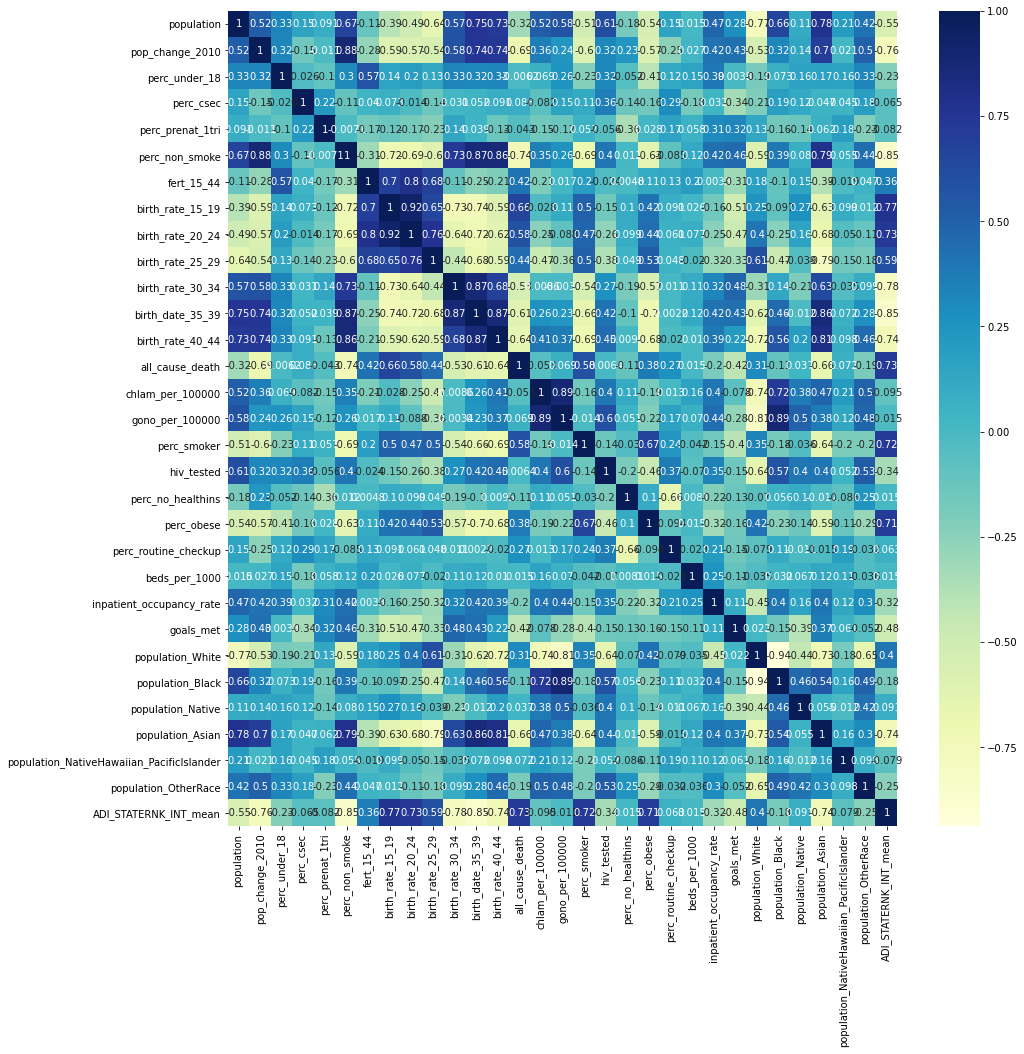

In [38]:
# plot correlation matrix
fig, ax = plt.subplots(figsize=(15,15)) 
heatmap = sns.heatmap(merged.corr(), cmap="YlGnBu", annot=True)

## Linear Regression Modelling

iteration #1: all features

In [39]:
lm = LinearRegression() #creating linear regression object
lm.fit(X_train, y_train) #fitting train data to model
print("Train R-squared: ", lm.score(X_train, y_train)) #getting train model R-squared
print("Train MSE: %.2f"% mean_squared_error(y_train, lm.predict(X_train))) #getting MSE for train data

cross_val = KFold(n_splits=10, random_state=None, shuffle=False) #creating k-fold cross validation object
score_lm = cross_val_score(lm, X_train, y_train, 
                             scoring="neg_mean_squared_error", cv=cross_val, n_jobs=-1) #getting CV scores for linear regression
lm_MSE_CV = np.abs(np.mean(score_lm)) #getting average CV error for linear regression
print("Linear Regression CV error:", lm_MSE_CV) #printing average CV error for linear regression

Train R-squared:  0.8256347181334919
Train MSE: 0.20
Linear Regression CV error: 1.4182110738511904


iteration #2: dropped less correlated variables

Train R-squared:  0.6957324446064934
Train MSE: 0.35
Linear Regression CV error: 1.4182110738511904


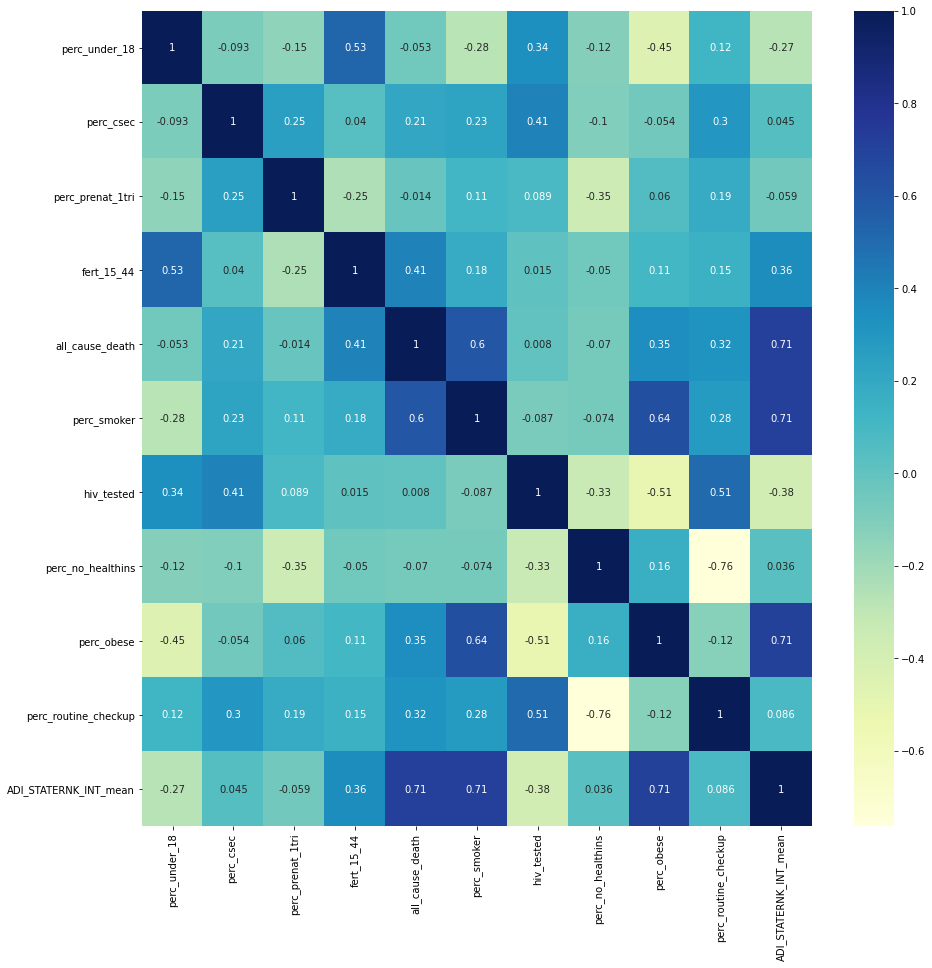

In [40]:
X_train_corr  = X_train.drop(columns = ['population', 'population_White', 'perc_non_smoke', 'population_Black', 'population_Native', 'population_Asian', 'population_NativeHawaiian_PacificIslander', 'population_OtherRace', 'beds_per_1000', 'gono_per_100000', 
                                        'chlam_per_100000', 'birth_rate_15_19', 'birth_rate_20_24', 'birth_rate_25_29', 'birth_rate_30_34', 'birth_date_35_39', 'birth_rate_40_44', 'pop_change_2010', 'inpatient_occupancy_rate'])
X_test_corr  = X_test.drop(columns = ['population', 'population_White', 'perc_non_smoke', 'population_Black', 'population_Native', 'population_Asian', 'population_NativeHawaiian_PacificIslander', 'population_OtherRace', 'beds_per_1000', 'gono_per_100000', 
                                        'chlam_per_100000', 'pop_change_2010','birth_rate_15_19', 'birth_rate_20_24', 'birth_rate_25_29', 'birth_rate_30_34', 'birth_date_35_39', 'birth_rate_40_44', 'inpatient_occupancy_rate'])

lm = LinearRegression() #creating linear regression object
lm.fit(X_train_corr, y_train) #fitting train data to model
print("Train R-squared: ", lm.score(X_train_corr, y_train)) #getting train model R-squared
print("Train MSE: %.2f"% mean_squared_error(y_train, lm.predict(X_train_corr))) #getting MSE for train data!

cross_val = KFold(n_splits=10, random_state=None, shuffle=False) #creating k-fold cross validation object
score_lm = cross_val_score(lm, X_train_corr, y_train, 
                             scoring="neg_mean_squared_error", cv=cross_val, n_jobs=-1) #getting CV scores for linear regression
lm_MSE_CV_corr = np.abs(np.mean(score_lm)) #getting average CV error for linear regression
print("Linear Regression CV error:", lm_MSE_CV) #printing average CV error for linear regression

fig, ax = plt.subplots(figsize=(15,15)) 
heatmap = sns.heatmap(X_train_corr.corr(), cmap="YlGnBu", annot=True)

iteration #3: polynomial linear regression

In [41]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
lm_poly = LinearRegression(normalize=True) #creating linear regression object
cross_val = KFold(n_splits=10, random_state=None, shuffle=False) #setting up 10-fold cross-validation
errors = [] #creating empty list to score average CV errors

for i in range(2,4): #iterating through degrees 2-7
    poly = PolynomialFeatures(degree=i) #polynomial transformation object
    X_poly_train = poly.fit_transform(X_train) #transforming training predictors
    model = lm_poly.fit(X_poly_train, y_train) #fitting polynomial predictors to regression
    scores = cross_val_score(model, X_poly_train, y_train, 
                             scoring="neg_mean_squared_error", cv=cross_val, n_jobs=-1) #getting errors across 10 folds
    print("Degree-"+str(i)+" polynomial MSE: " + str(np.mean(np.abs(scores))) + ", standard_dev: " + str(np.std(scores)))
    errors.append(np.mean(np.abs(scores))) #appending average MSE to errors list

Degree-2 polynomial MSE: 1.141763517618173, standard_dev: 1.1168434805801943
Degree-3 polynomial MSE: 1.1451678280226736, standard_dev: 1.3155566940173804


In [42]:
poly_minerror = np.min((errors)) #storing the min CV error
print('Minimum CV error for polynomial regression (degree=2):', poly_minerror)

Minimum CV error for polynomial regression (degree=2): 1.141763517618173


iteration #4: Sequntial Feature Selection method to check # features vs. performance

In [43]:
from sklearn.feature_selection import SequentialFeatureSelector
model= LinearRegression(normalize=True) #creating model object
predictors = X_train.columns.values #saving column names of predictors
CV_scores = [] #creating empty list to score average CV errors

for i in range(1, np.shape(X_train)[1]): #looping through n-1 features
    print("Num Features:",i)
    sfs = SequentialFeatureSelector(model, 
                                    n_features_to_select = i, 
                                    direction="forward",
                                    scoring='neg_mean_squared_error',
                                    cv=10) 
    sfs = sfs.fit(X_train, y_train) #selecting i features using training data
    print("\tFeatures selected:", list(predictors[sfs.get_support()])) #getting selected features for given i
    x_subset = sfs.transform(X_train) #transforming predictors dataframe based on selected features
    CV_error = np.mean(cross_val_score(model, x_subset, y_train, cv=10, scoring='neg_mean_squared_error'))
    #getting mean cv score for linear regression fitted to training data with selected features
    CV_scores.append(CV_error) #appending average CV error to CV scores list
    print("\tCV_Error: %10.3f"%CV_error)

Num Features: 1
	Features selected: ['birth_rate_15_19']
	CV_Error:     -0.897
Num Features: 2
	Features selected: ['perc_csec', 'birth_rate_15_19']
	CV_Error:     -0.767
Num Features: 3
	Features selected: ['perc_csec', 'perc_prenat_1tri', 'birth_rate_15_19']
	CV_Error:     -0.610
Num Features: 4
	Features selected: ['perc_csec', 'perc_prenat_1tri', 'birth_rate_15_19', 'gono_per_100000']
	CV_Error:     -0.562
Num Features: 5
	Features selected: ['perc_csec', 'perc_prenat_1tri', 'birth_rate_15_19', 'birth_date_35_39', 'gono_per_100000']
	CV_Error:     -0.483
Num Features: 6
	Features selected: ['perc_csec', 'perc_prenat_1tri', 'birth_rate_15_19', 'birth_date_35_39', 'gono_per_100000', 'hiv_tested']
	CV_Error:     -0.464
Num Features: 7
	Features selected: ['perc_csec', 'perc_prenat_1tri', 'birth_rate_15_19', 'birth_date_35_39', 'birth_rate_40_44', 'gono_per_100000', 'hiv_tested']
	CV_Error:     -0.435
Num Features: 8
	Features selected: ['perc_csec', 'perc_prenat_1tri', 'birth_rate_15_

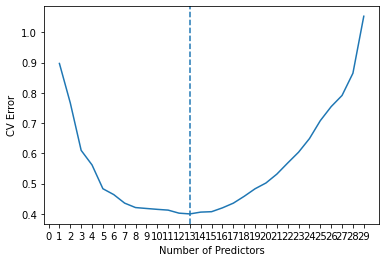

In [44]:
CV_scores =np.abs(CV_scores) #get the absolute value of the CV errors since we used negative MSE above
MSE_LR = np.min(CV_scores) #save the lowest MSE

x_graph = list(range(1,len(predictors))) #store range of features
best_CV = (np.where(CV_scores == np.min(CV_scores))[0])+1 #storing lowest CV error
plt.plot(x_graph,CV_scores) #plotting CV error for each # of features
plt.xlabel("Number of Predictors") #labeling x axis
plt.xticks(range(len(predictors))) #specifying x ticks
plt.ylabel("CV Error") #labeling y axis
plt.axvline(x=best_CV,linestyle='--') #adding vertical line for lowest CV error
plt.show() #showing plot

In [48]:
# selected based on SFS
X_train_fs = X_train[['perc_csec', 'perc_prenat_1tri', 'birth_rate_15_19', 'birth_rate_20_24', 'birth_rate_25_29', 'birth_rate_30_34', 'birth_date_35_39', 'gono_per_100000', 'perc_smoker', 'hiv_tested', 'perc_no_healthins', 'perc_obese', 'beds_per_1000', 'population_White', 'population_Black', 'population_Native', 'population_Asian', 'population_OtherRace', 'ADI_STATERNK_INT_mean']]

X_test_fs = X_test[['perc_csec', 'perc_prenat_1tri', 'birth_rate_15_19', 'birth_rate_20_24', 'birth_rate_25_29', 'birth_rate_30_34', 'birth_date_35_39', 'gono_per_100000', 'perc_smoker', 'hiv_tested', 'perc_no_healthins', 'perc_obese', 'beds_per_1000', 'population_White', 'population_Black', 'population_Native', 'population_Asian', 'population_OtherRace', 'ADI_STATERNK_INT_mean']]

In [49]:
lm = LinearRegression() #creating linear regression object
lm.fit(X_train_fs, y_train) #fitting train data to model
print("Train R-squared: ", lm.score(X_train_fs, y_train)) #getting train model R-squared
print("Train MSE: %.2f"% mean_squared_error(y_train, lm.predict(X_train_fs))) #getting MSE for train data


Train R-squared:  0.7600022334540522
Train MSE: 0.28


iteration #5: add regularizers 

In [50]:
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
feature_names=X_train.columns.values #storing feature names

model_ridge = Ridge(normalize=True) #creating ridge model object
errors= [] #empty list to store errors
coef = [] #empty list to store coefficient estimates for graphing 


alphas = np.logspace(-5, 5, 300) #setting logspace range for alphas
for a in alphas: #iterating through alphas
    model_ridge.set_params(alpha=a) #setting alpha parameter for ridge model
    model_ridge.fit(X_train, y_train) #fitting model to training data
    CV_error = np.mean(cross_val_score(model_ridge, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    #getting average CV error for specific alpha using training data
    errors.append(CV_error) #storing average CV error in list
    coef.append(model_ridge.coef_) #storing coefficient estimates in list for graphing later
    
errors = np.abs(errors) #storing absolute value of errors bc we used neg MSE above
print("Min error: ", np.min(errors)) #printing min CV error
ridge_ME = np.min(errors) #storing min error for model selection later
index_ME = (np.where(errors == np.min(errors))[0]) #storing index for min CV error to get best alpha
print("Best alpha: ", alphas[index_ME]) #printing best alpha

Min error:  0.5528433070791682
Best alpha:  [0.51965973]


In [51]:
model_lasso = Lasso(normalize=True, max_iter = 100000) #creating lasso model object
errors_lasso = [] #empty list to store errors
coef_lasso = [] #empty list to store coefficient estimates for graphing 

alphas = np.logspace(-5, 5, 300) #setting logspace range for alphas
for a in alphas: #iterating through alphas
    model_lasso.set_params(alpha=a) #setting model parameter to specific alpha
    model_lasso.fit(X_train, y_train) #fitting lasso model to training data
    CV_error = np.mean(cross_val_score(model_lasso, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    #getting mean CV error using training data
    errors_lasso.append(CV_error) #appending mean CV error to list for graphing
    coef_lasso.append(model_lasso.coef_) #appending coefficient weights to list for graphing
    
errors_lasso = np.abs(errors_lasso) #getting asbolute value since negative MSE is used above
print("Min error: ", np.min(errors_lasso)) #printing min error
lasso_ME = np.min(errors_lasso) #storing min error
lasso_index_ME = (np.where(errors_lasso == np.min(errors_lasso))[0])
#storing index of min error to get best alpha
print("Best alpha: ", alphas[lasso_index_ME]) #getting best alpha using index stored in line above

Min error:  0.6052016458083405
Best alpha:  [0.00947521]


### Overall Evaluation of all linear models built

In [52]:
print('Avg CV MSE for Linear Regression: %.4f'% lm_MSE_CV)
print('Avg CV MSE for Linear Regression with Manual Feature Selection: %.4f'% lm_MSE_CV_corr)
print('Lowest SFS Linear Regression CV MSE, 19 features: %.4f'% MSE_LR)
print('Lowest Ridge CV MSE with best alpha: %.4f'% ridge_ME)
print('Lowest Lasso CV MSE with best alpha: %.4f'% lasso_ME)

Avg CV MSE for Linear Regression: 1.4182
Avg CV MSE for Linear Regression with Manual Feature Selection: 0.5740
Lowest SFS Linear Regression CV MSE, 19 features: 0.3998
Lowest Ridge CV MSE with best alpha: 0.5528
Lowest Lasso CV MSE with best alpha: 0.6052


In [53]:
lm = LinearRegression() #create linear reg object
lm.fit(X_train, y_train) #fitting to training data
lm_model_pred_y = lm.predict(X_test) #using fit model to predict y for test data
lm_model_test_MSE = mean_squared_error(lm_model_pred_y, y_test) #get test MSE
print("Linear Regression Test MSE:", lm_model_test_MSE)

lm = LinearRegression() #create linear reg object
lm.fit(X_train_corr, y_train) #fitting to training data
lm_model_pred_y = lm.predict(X_test_corr) #using fit model to predict y for test data
lm_corr_test_MSE = mean_squared_error(lm_model_pred_y, y_test) #get test MSE
print("Linear Regression Corr Test MSE:", lm_corr_test_MSE)

sfs = SequentialFeatureSelector(model, 
                                n_features_to_select = 19, 
                                direction="forward",
                                scoring='neg_mean_squared_error',
                                cv=10) #create SFS using n=17
sfs = sfs.fit(X_train, y_train) #selecting 5 features using training data
x_subset = sfs.transform(X_train) #transforming x train data
x_subset_test = sfs.transform(X_test) #transforming x test data
lm.fit(x_subset, y_train) #fitting SFS linear model using transformed x train data
y_pred = lm.predict(x_subset_test) #predict y test using transformed x data and fitted model
sfs_MSE = mean_squared_error(y_pred, y_test) #get test MSE
print("SFS Linear Regression Test MSE:", sfs_MSE)

model_ridge.set_params(alpha=alphas[index_ME]) #set params for ridge using best alpha
y_pred = model_ridge.predict(X_test) #predict y using x test data
MSE_test_ridge = mean_squared_error(y_test, y_pred) #get test MSE
print("Ridge Regression Test MSE:", MSE_test_ridge)

model_lasso.set_params(alpha=alphas[lasso_index_ME]) #set params for ridge using best alpha
y_pred = model_lasso.predict(X_test) #predict y using x test data
MSE_test_lasso = mean_squared_error(y_test, y_pred) #get test MSE
print("Lasso Regression Test MSE:", MSE_test_lasso)

Linear Regression Test MSE: 0.7980500915939869
Linear Regression Corr Test MSE: 1.2092202252612227
SFS Linear Regression Test MSE: 0.8056581364906116
Ridge Regression Test MSE: 1.4525880522459684
Lasso Regression Test MSE: 1.4526562500000002


### Selecting weights for optimization 

In [54]:
import statsmodels.api as sm
from regressors import stats
import itertools

In [55]:
lm = LinearRegression()
lm.fit(X_train, y_train)

coefs = []
coefs.append(lm.intercept_)
for coef in lm.coef_:
    coefs.append(coef)

pd.DataFrame(zip(X_train.columns, coefs, stats.coef_pval(lm, X_train, y_train)), columns = ['feature', 'coefficient estimate', 'p-value'])

,feature,coefficient estimate,p-value
0,population,-1.284780e+01,1.564800e-01
1,pop_change_2010,-9.007174e-07,6.916945e-01
2,perc_under_18,-1.404969e-01,1.017505e-03
3,perc_csec,2.128209e-02,5.960509e-01
4,perc_prenat_1tri,-1.456378e-01,4.797403e-09
5,perc_non_smoke,8.057400e-02,1.550935e-09
6,fert_15_44,1.322918e-01,5.269638e-07
7,birth_rate_15_19,2.594706e-02,6.514938e-01
8,birth_rate_20_24,5.841206e-02,1.354952e-01
9,birth_rate_25_29,-1.021938e-02,9.455472e-02


In [57]:
lm = LinearRegression()
lm.fit(X_train_fs, y_train)
y_pred = lm.predict(X_test_fs)

coefs = []
coefs.append(lm.intercept_)
feature_names = ['intercept']
for col in X_train_fs.columns:
    feature_names.append(col)
for coef in lm.coef_:
    coefs.append(coef)

results = pd.DataFrame(zip(feature_names, coefs, stats.coef_pval(lm, X_train_fs, y_train)), columns = ['feature', 'coefficient estimate', 'p-value'])
results
#results.to_csv('regression_results.csv') #saved for optimization weights

,feature,coefficient estimate,p-value
0,intercept,-17.549108,8.481248e-03
1,perc_csec,-0.147537,4.929074e-09
2,perc_prenat_1tri,0.068303,1.445073e-10
3,birth_rate_15_19,0.057591,5.388681e-02
4,birth_rate_20_24,-0.004629,2.257494e-01
5,birth_rate_25_29,-0.021213,2.085863e-05
6,birth_rate_30_34,0.015933,2.618331e-02
7,birth_date_35_39,0.028186,4.034266e-02
8,gono_per_100000,-0.005124,3.579786e-03
9,perc_smoker,-0.028983,1.498304e-01


In [58]:
lm = LinearRegression()
lm.fit(X_train_corr, y_train)

coefs = []
coefs.append(lm.intercept_)
for coef in lm.coef_:
    coefs.append(coef)

pd.DataFrame(zip(X_train_corr.columns, coefs, stats.coef_pval(lm, X_train_corr, y_train)), columns = ['feature', 'coefficient estimate', 'p-value'])

,feature,coefficient estimate,p-value
0,perc_under_18,14.570343,8.137756e-03
1,perc_csec,-0.004047,9.278744e-01
2,perc_prenat_1tri,-0.111042,2.089064e-05
3,fert_15_44,0.063886,1.461265e-07
4,all_cause_death,-0.007103,5.249984e-01
5,perc_smoker,0.003950,0.000000e+00
6,hiv_tested,-0.047754,2.941331e-02
7,perc_no_healthins,-0.043739,2.021841e-02
8,perc_obese,-0.135284,7.514802e-07
9,perc_routine_checkup,0.055332,2.436500e-02
